## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [104]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [25]:
# init model & load data
data_path = '../data/toy1_longer'#toy1.npy'
model_path = '../model/toy1_longer'#pace_models'
result_path = '../result/toy1_longer/'

full_data_path = os.path.join(data_path, 'data.npy')

dataset = net.MultiScaleDynamicsDataSet(full_data_path, n_levels=5, shuffle=False)

self.data.shape =  torch.Size([5000, 1, 127, 127])


In [23]:
# training
archs = [[1]]#,[1,3,5,7]]
tols = [0.001]#, 0.0005]#, 0.0001]
# net.train_net(archs=archs, dataset=dataset, max_epoch=3000, batch_size=350, 
#               tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
#               result_path=result_path, std=0.01, verbose=3)

#start with deepening
try:
    model_space = torch.load(os.path.join(model_path, 'model_L0_0.pt'))
except:
    print("training new stage")
#     model_space = net.train_net_one_stage(mode=1, n_filters=1, dataset=dataset, max_epoch=3000, batch_size=350, result_path = result_path,
#                         load_model=None, tol=tols[0],std=0.01,  model_path=model_path, verbose=3)

In [26]:
print(model_space.cur_level)
all_data = dataset.obtain_data_at_current_level_all(model_space.cur_level)
print(all_data.shape)
train_data, val_data, test_data =dataset.obtain_data_at_current_level(model_space.cur_level)
encoded = model_space.encode(all_data, model_space.cur_level)
print(encoded.shape)
train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_encoded.shape)
print(val_encoded.shape)
print(test_encoded.shape)

0
torch.Size([5000, 1, 7, 7])
torch.Size([5000, 1, 3, 3])
torch.Size([1, 3500, 9])
torch.Size([1, 1000, 9])
torch.Size([1, 500, 9])


torch.Size([5000, 1, 3, 3])


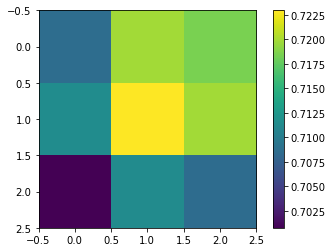

In [6]:
print(encoded.shape)
plt.imshow(encoded[0,0].detach().numpy())
plt.colorbar()

In [44]:
#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy1_longer'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 7
max_k = 8

print(val_encoded.shape)
_,n_steps, total_dim= val_encoded.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

torch.Size([1, 1000, 9])
total_dim =  9


In [10]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name))
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

k =  7
load model_D128.pt


In [11]:
val_encoded.shape

torch.Size([1, 1000, 9])

torch.Size([1, 1000, 9])
y_preds.shape = torch.Size([1, 999, 9])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 999])
1

err.shape =  torch.Size([1, 999])
(999,)


<ipython-input-45-3407d4bb2a8f>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
<ipython-input-45-3407d4bb2a8f>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1).shape )
<ipython-input-45-3407d4bb2a8f>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_mse.append(criterion(torch.tensor(v

(1e-05, 10)

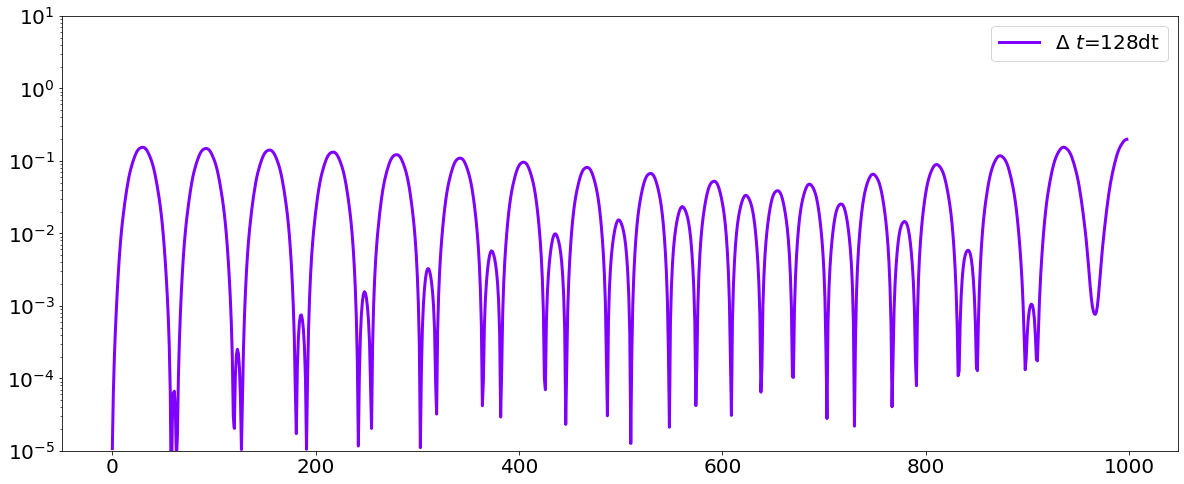

In [45]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
    print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds).mean(-1))
    print(len(preds_mse))
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
    print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
# plt.xlim([0, len(t)])
    

(1e-05, 10)

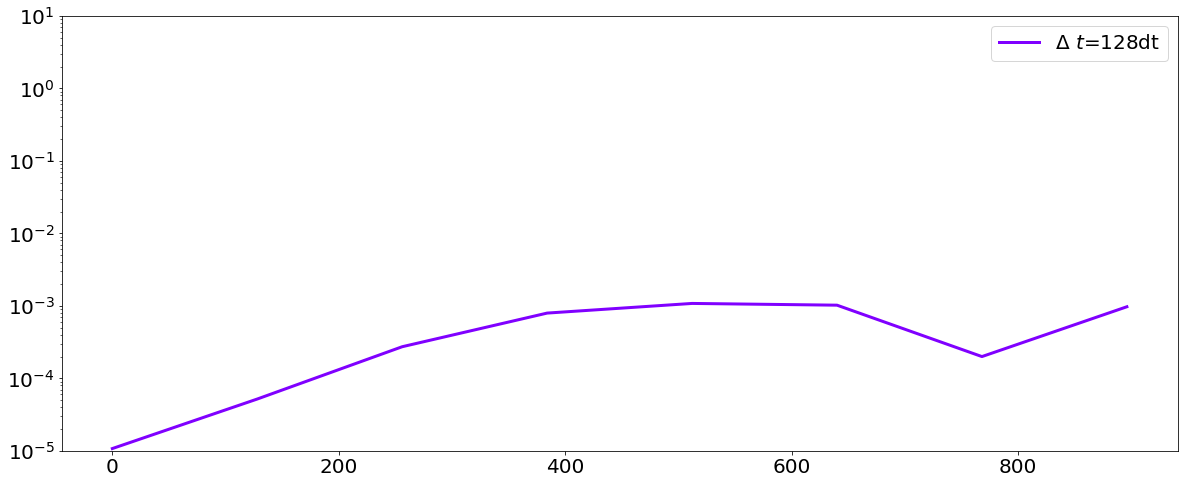

In [46]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k]
    t = range(len(mean))
    plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [99]:
#need to predict encoded dta in time and then decode

print(n_steps)
train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, :]).float(), n_steps=len(test_encoded[0])-1)
print(criterion(torch.tensor(train_encoded[:, 1:, :]).float(), train_preds_time).mean(-1).mean())
print(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), val_preds_time).mean(-1).mean())
print(criterion(torch.tensor(test_encoded[:, 1:, :]).float(), test_preds_time).mean(-1).mean())
# train_encoded

#decode
print(train_preds_time.reshape((3499,3,3)).shape)
to_decode_train = torch.tensor(train_preds_time.reshape((3499,3,3))).unsqueeze(1).float()
train_decoded = model_space.decode(to_decode_train, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(train_decoded.shape)

print(val_preds_time.shape)
to_decode_val = torch.tensor(val_preds_time.reshape((999,3,3))).unsqueeze(1).float()
val_decoded = model_space.decode(to_decode_val, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))

print(test_preds_time.shape)
to_decode_test = torch.tensor(test_preds_time.reshape((len(test_preds_time[0]),3,3)).unsqueeze(1).float())
test_decoded = model_space.decode(to_decode_test, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(test_decoded.shape)

999
tensor(24.2636)
tensor(0.0384)
tensor(0.0437)
torch.Size([3499, 3, 3])
torch.Size([3499, 1, 7, 7])
torch.Size([1, 999, 9])
torch.Size([1, 499, 9])
torch.Size([499, 1, 7, 7])


<ipython-input-99-43de40601631>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
<ipython-input-99-43de40601631>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
<ipython-input-99-43de40601631>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, 

torch.Size([3499, 1, 7, 7])


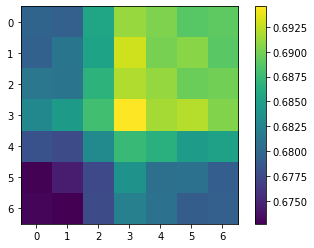

torch.Size([3500, 1, 7, 7])


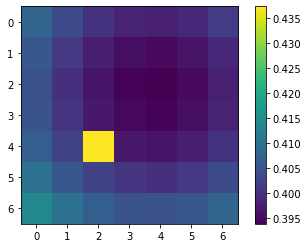

torch.Size([3499])


<ipython-input-89-5f51007ffe1f>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))


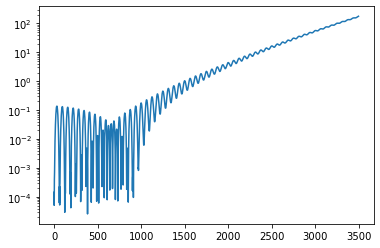

In [89]:
print(train_decoded.shape)
plt.imshow(train_decoded[20,0].detach().numpy())
plt.colorbar()
plt.show()
print(train_data.shape)
plt.imshow(train_data[21,0].detach().numpy())
plt.colorbar()
plt.show()

mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))
print(mse.shape)
plt.semilogy(mse)

torch.Size([1, 499, 9])
torch.Size([999])


<ipython-input-102-3b41dfcb6fbd>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))


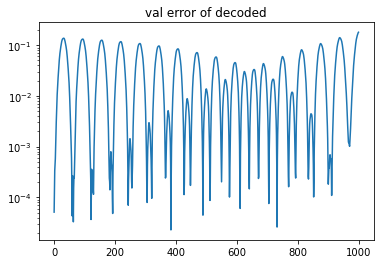

torch.Size([1, 499, 9])
torch.Size([499])


<ipython-input-102-3b41dfcb6fbd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))


Text(0.5, 1.0, 'test error of decoded')

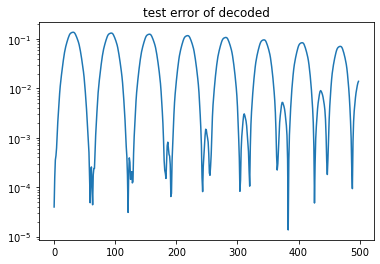

In [102]:

print(test_preds_time.shape)
mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("val error of decoded")
plt.show()

print(test_preds_time.shape)
mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("test error of decoded")

Animating, may take a little while...
..................Done! gif saved to  ../result/toy1_longer/decoded_test_7x7.gif


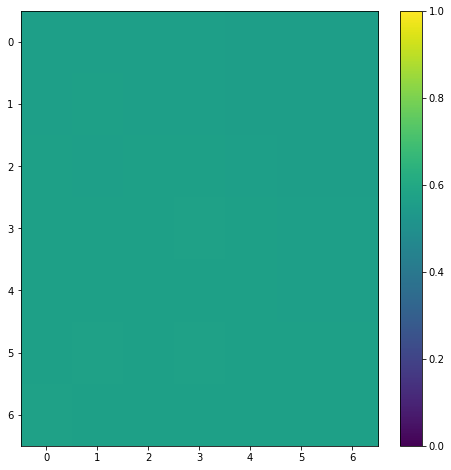

In [107]:
utils.animate(test_decoded.detach().numpy(), os.path.join(result_path, 'decoded_test_7x7.gif'))

In [ ]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    print(file_name)
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

model = models['model_L0_0']

In [ ]:
model = models['model_L0_0']
i = 0

_, _, data = dataset.obtain_data_at_current_level(level=1)
print()
# print(model.cur_level)
output, _, _, _ = model(data[[0], :, :, :], model.cur_level, verbose = True)

In [ ]:
def apply_local_op(data, mode='conv', ave=True):
    """
    :param data: data to be processed
    :param device: which device is the data placed in?
    :param mode: string, 'conv' or 'deconv'
    :param ave: if to use local average or sample the center
    :return: processed data
    """
    in_channels, out_channels, n_per_dim, _ = data.size()
    n = min(in_channels, out_channels)
    print("data.size() = ", data.size())
#     in_channels= 1
#     out_channels = 1
#     n = 1
    op = torch.nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=0)
    op.weight.data = torch.zeros(op.weight.data.size())
    print("op.weight.data = ", op.weight.data.size())
    op.bias.data = torch.zeros(op.bias.data.size())
    for i in range(n):
        print("op.weight.data[i, i, 1, 1].size() = ", op.weight.data[i, i, 1, 1].size())
        op.weight.data[i, i, 1, 1] = torch.ones(op.weight.data[i, i, 1, 1].size())

    # make them non-trainable
    for param in op.parameters():
        param.requires_grad = False

    transformed = np.zeros((in_channels, out_channels, n_per_dim//2, n_per_dim//2))
    print("transformed shape = ", transformed.shape)
#     for i in range(in_channels//)
#     print(op(data).shape)
    return op(data)


#save encoded data

to_encode_path = os.path.join(data_path, 'data.npy')
to_encode_raw = np.load(to_encode_path)
print("to_encode_raw shape = ", to_encode_raw.shape)

n_levels = 5
level = 0
to_encode = torch.tensor(to_encode_raw).unsqueeze(1).float()

# to_encode_right_size = torch.zeros((to_encode.size()))

# n_runs, _,_,_ = to_encode.size()

# for r in range(n_runs):
#     print("r = ", r)
# to_encode_this = to_encode[0].unsqueeze(1).float()
for i in range(n_levels - level - 1):
    to_encode = apply_local_op((to_encode), ave=False)
#     to_encode_right_size[r, :,0,:,:] = to_encode_data
    
print("to_encode shape = ", to_encode.shape)


# return train_data
    
# np.save(full_data_path, scaled_Phi.T)

# dataset_encode = net.MultiScaleDynamicsDataSet(to_encode_path, n_levels=5)

level = 0
filter_group_num = 0
model = models['model_L{}_{}'.format(level, filter_group_num)]
# data = dataset_encode.obtain_data_at_current_level_all(level=0)

encoded = model.encode(to_encode, model.cur_level)#, verbose = True)
# decoded = model.decode(encoded, model.cur_level)

print(encoded.shape)
# print(decoded.shape)

#save encoded data 
np.save(os.path.join(data_path, 'data_L{}_{}'.format(level, filter_group_num)), encoded.detach().numpy())

In [ ]:
model = models['model_L0_0']
i = 0

_, _, data = dataset.obtain_data_at_current_level(level=0)
print(data.shape)
# print(model.cur_level)
output, _, _, _ = model(data[[0], :, :, :], model.cur_level, verbose = True)

plt.imshow(output[-0,0].detach().numpy())
plt.colorbar()
plt.show()

encoded = model.encode(data[[0], :, :, :], model.cur_level)#, verbose = True)
decoded = model.decode(encoded, model.cur_level)#, verbose = True)

plt.imshow(decoded[-1,0].detach().numpy())
plt.colorbar()
plt.show()


In [ ]:
plt.imshow(encoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
i = 0
_, _, data = dataset.obtain_data_at_current_level(level=0)
output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)

# plt.imshow(data[0,0,])


print(output.shape)
encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)
print(encoded.shape)
decoded = model.decode(encoded, model.cur_level)
print(decoded.shape)

plt.imshow(output[0,0].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(decoded[0,0].detach().numpy())
plt.colorbar()
plt.show()

print(output)
print(decoded)

In [ ]:
def apply_mask(data, mask, mask_type='resolved', width=1):
    """
    :param data: data to be processed
    :param mask: mask, a 2D torch tensor of 0s and 1s
    :param mask_type: resolved map or unresolved map
    :param width: int, specify how large the region is
    :return: a 4D torch tensor represents masked data
    """
    if not isinstance(width, int):
        raise ValueError('width should be a positive integer!')

    # convert to unresolved mask
    if mask_type == 'resolved':
        mask = 1 - mask
        print(mask)
    elif mask_type == 'unresolved':
        mask = mask
    else:
        raise ValueError('mask_type could only be resolved or unresolved!')

    # expansion
    dx = [i for i in range(-width, width+1)]
    dy = [i for i in range(-width, width+1)]
    
    print("dx = ", dx)
    print("dy = ", dy)
    m, n = mask.size()
    print("mask.nonzero() = ", mask.nonzero())
    for c in mask.nonzero():
        x, y = int(c[0]), int(c[1])
        for i in range(2*width+1):
            for j in range(2*width+1):
#                 print(i, ": ", j)
                if 0 <= x + dx[i] < m and 0 <= y + dy[j] < n:
#                     print("x + dx[i] =", x + dx[i])
                    mask[x + dx[i], y + dy[j]] = 1

    # apply
#     print("data shape = ", data.shape)
#     print("mask.unsqueeze(0).unsqueeze(0).float() shape = ", mask.unsqueeze(0).unsqueeze(0).float().shape)
    print("mask.unsqueeze(0).unsqueeze(0).float()= ", mask.unsqueeze(0).unsqueeze(0).float())
    masked_data = data * mask.unsqueeze(0).unsqueeze(0).float()
    return masked_data

# x = torch.tensor([[[[1, 2, 3, 4, 5, 6], [4, 5, 6, 7, 8, 9, ], [7, 8, 9, 10, 11, 12]]]])
# mask = torch.tensor([[0,0,0,0,0,0]]

print(x.shape)
print(mask.size())
masked_x = apply_mask(x, mask)
print(masked_x)

## Results

In [ ]:
# trained models at different levels
models = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models[model_name] = torch.load(os.path.join(model_path, file_name))

In [ ]:
print(model.resolved_maps['0']['0'].cpu().detach().numpy().shape)
print(model.resolved_maps['2']['3'].cpu().detach().numpy().shape)

print(model.parameters())
# for param in model.parameters():
#     print(param)

for name, param in model.named_parameters():
    print( name ," : ", param.shape)

In [ ]:
# choose the finest model
model = models['model_L2_3']

# resolved maps at different levels (that suggest poorly reconstructed regions)
for i in range(3):
    print(model.resolved_maps[str(i)].keys())

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['0']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L0_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I0.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I1.png'))


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['1']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L1_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['0'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I0.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['1'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I1.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['2'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I2.png'))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(model.resolved_maps['2']['3'].cpu().detach().numpy(), cmap='binary', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(os.path.join(result_path, 'L2_I3.png'))

In [ ]:
inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
# model = models['model_L2_3']

_, _, data = dataset.obtain_data_at_current_level(level=4)
i = 0

model = models['model_L0_0']
encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
print(encoded.shape)
plt.imshow(encoded[0].detach().numpy())
plt.colorbar()
plt.show() 


x = model(data[[i*n_step], :, :, :], model.cur_level)[0]
print(x.shape)
plt.imshow(x[0,0].detach().numpy())
plt.colorbar()
plt.show() 



# model = models['model_L2_1']
# encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
# print(encoded.shape)
# plt.imshow(encoded[0].detach().numpy())
# plt.colorbar()
# plt.show()

# model = models['model_L2_2']
# encoded = model.encode(data[[i*n_step], :, :, :], model.cur_level)[0]
# print(encoded.shape)
# plt.imshow(encoded[0].detach().numpy())


In [ ]:
model = models['model_L0_3']# plt.colorbar()
print(len(model.resolved_maps))
print(model.resolved_maps.keys())

# print(model.resolved_maps['0']['0'])
plt.imshow(model.loss_each_stage['0']['0'].detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(model.resolved_maps['0']['0'])
plt.show()
plt.imshow(model.loss_each_stage['0']['1'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['1'])
plt.show()

plt.imshow(model.loss_each_stage['0']['2'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['2'])
plt.show()

plt.imshow(model.loss_each_stage['0']['3'].detach().numpy())
plt.colorbar()
plt.show()
plt.imshow(model.resolved_maps['0']['3'])
plt.show()


In [ ]:
# reconstructions of test snapshots

inds = np.array(sorted(dataset.test_inds))
dataset.test_inds = inds
n_snapshots = len(inds)
n_samples = 6
n_step = n_snapshots // 6

fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    axes[i].pcolor(dataset.data[inds[i*n_step], :, :, :].squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_samples.png'), bbox_inches='tight')


model = models['model_L0_1']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=0)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L0_reconstructions.png'), bbox_inches='tight')


model = models['model_L1_2']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=1)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L1_reconstructions.png'), bbox_inches='tight')


model = models['model_L2_3']
fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*11, 10))
plt.subplots_adjust(wspace=0.01)
for i in range(n_samples):
    _, _, data = dataset.obtain_data_at_current_level(level=2)
    output, _, _, _ = model(data[[i*n_step], :, :, :], model.cur_level)
    axes[i].pcolor(output.squeeze().cpu().detach().numpy(), cmap='viridis')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
fig.savefig(os.path.join(result_path, 'test_L2_reconstructions.png'), bbox_inches='tight')

In [ ]:
fig1, axes = plt.subplots(2, 1, figsize=(8, 16))
axes[0].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi1(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')
axes[1].pcolor(xgrid[:,:,0], ygrid[:,:,0], phi2(xgrid, ygrid, tgrid)[:, :, 0].T, cmap='viridis')

axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig1.savefig(os.path.join(result_path, 'spatial_dynamics.png'))

fig2, axes = plt.subplots(2, 1, figsize=(14*7, 24))
axes[0].plot(t, np.cos(w0*t), t[inds[::n_step]], np.cos(w0*t[inds[::n_step]]), 'r.', linewidth=20, markersize=80)
axes[1].plot(t, np.cos(w1*t + np.pi/4), t[inds[::n_step]], np.cos(w1*t[inds[::n_step]] + np.pi/4), 'r.', linewidth=20, markersize=80)
#
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_yticks([])
axes[1].set_yticks([])

fig2.savefig(os.path.join(result_path, 'temporal_dynamics.png'))

In [ ]:
records = {}
for file_name in sorted(os.listdir(result_path)):
    if file_name.endswith('.dat'):
        key, _ = file_name.split('.')
        with open(os.path.join(result_path, file_name), 'rb') as f: 
            records[key]= pickle.load(f)

In [ ]:
n_colors = 4
colors = [(51/255, 51/255, 255/255)]+ \
         [(204/255, 153/255, 255/255), 
          (178/255, 102/255, 255/255),
          (153/255, 51/255, 255/255),
          (127/255, 0/255, 255/255),
          (102/255, 0/255, 204/255),
          (76/255, 0/255, 153/255)]

fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(80, 16))

# plot
s = 0
for i in range(3):
    level_errs = records['val_errs'][i]
    n_widens = len(level_errs)
    ax1.axvline(x=s, color='k', linestyle='--', linewidth=20)
    for j in range(n_widens):
        op_err = level_errs[j]
        ax1.plot(range(s, s + len(op_err)), np.log(op_err), color=colors[j], linewidth=20)
        s += len(op_err)
        
ax1.axvline(x=s-1, color='k', linestyle='--', linewidth=20)

ax1.xaxis.set_tick_params(labelsize=100)
ax1.yaxis.set_tick_params(labelsize=100)

fig1.savefig(os.path.join(result_path, 'err_iter_plot.png'))